In [299]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

rng = np.random.default_rng()

In [300]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c', 'log_x0']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej', 'log_vej', 'log_fni']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
        self.ibc_fit.update({'log_vej': np.log10(self.ibc_fit['vej'])})

In [301]:
class real_SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_redshift):
        self.true_class = true_class
        self.true_redshift = true_redshift
        # if self.true_class == 'ia':
        #     self.true_params = {key:true_dict[key] for key in self.ia_keys}
        # elif self.true_class == 'ibc':
        #     self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        # else:
        #     raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}

In [302]:
data = np.load("fitted_sne_real_011526.npz", allow_pickle=True)
phot_data = np.load("fitted_sne_real_012126_phot.npz", allow_pickle=True)

true_ia_sne = data['ia']
true_ibc_sne = data['ibc']
all_sne = np.concatenate((true_ia_sne, true_ibc_sne))
true_ia_phot_sne = phot_data['ia']
true_ibc_phot_sne = phot_data['ibc']
all_phot_sne = np.concatenate((true_ia_phot_sne, true_ibc_phot_sne))
len(true_ibc_sne), len(all_sne), len(true_ia_sne)/len(all_sne)


(251, 497, 0.4949698189134809)

In [303]:
for sn in all_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

for sn in all_phot_sne:
    sn.ibc_fit.update({'log_vej': np.log10(sn.ibc_fit['vej'])})
    sn.ia_fit.update({'log_x0': np.log10(sn.ia_fit['x0'])})
    sn.ibc_fit.update({'log_fni': np.log10(sn.ibc_fit['fni'])})

In [304]:
all_sne[100].true_class

'SN Ia'

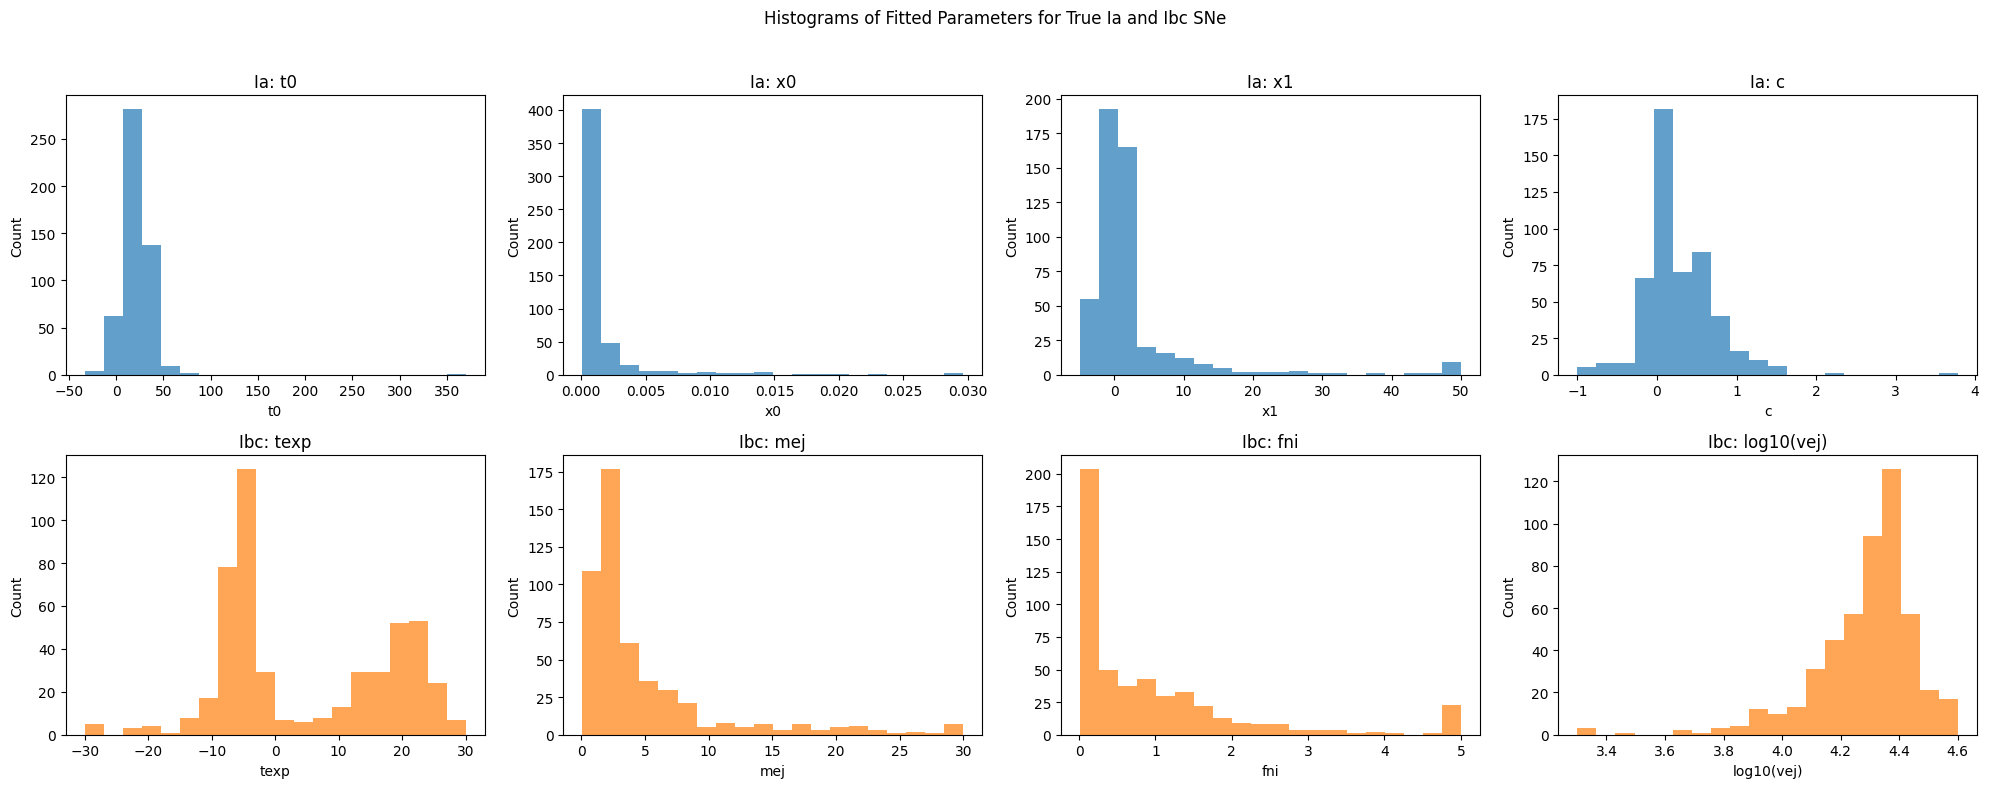

In [305]:
ia_param_names = SN.ia_keys[1:]  # ['t0', 'x0', 'x1', 'c']
ibc_param_names = SN.ibc_keys[1:]  # ['texp', 'mej', 'fni', 'vej']

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    values = [sn.ia_fit[param] for sn in all_sne if sn.ia_fit[param] is not None]
    axes[0, i].hist(values, bins=20, color='tab:blue', alpha=0.7)
    axes[0, i].set_title(f"Ia: {param}")
    axes[0, i].set_xlabel(param)
    axes[0, i].set_ylabel("Count")

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    values = [sn.ibc_fit[param] for sn in all_sne if sn.ibc_fit[param] is not None]
    if param == 'vej':
        # Plot log10 for vej
        values = [np.log10(v) for v in values if v > 0]
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: log10({param})")
        axes[1, i].set_xlabel(f"log10({param})")
    else:
        axes[1, i].hist(values, bins=20, color='tab:orange', alpha=0.7)
        axes[1, i].set_title(f"Ibc: {param}")
        axes[1, i].set_xlabel(param)
    axes[1, i].set_ylabel("Count")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

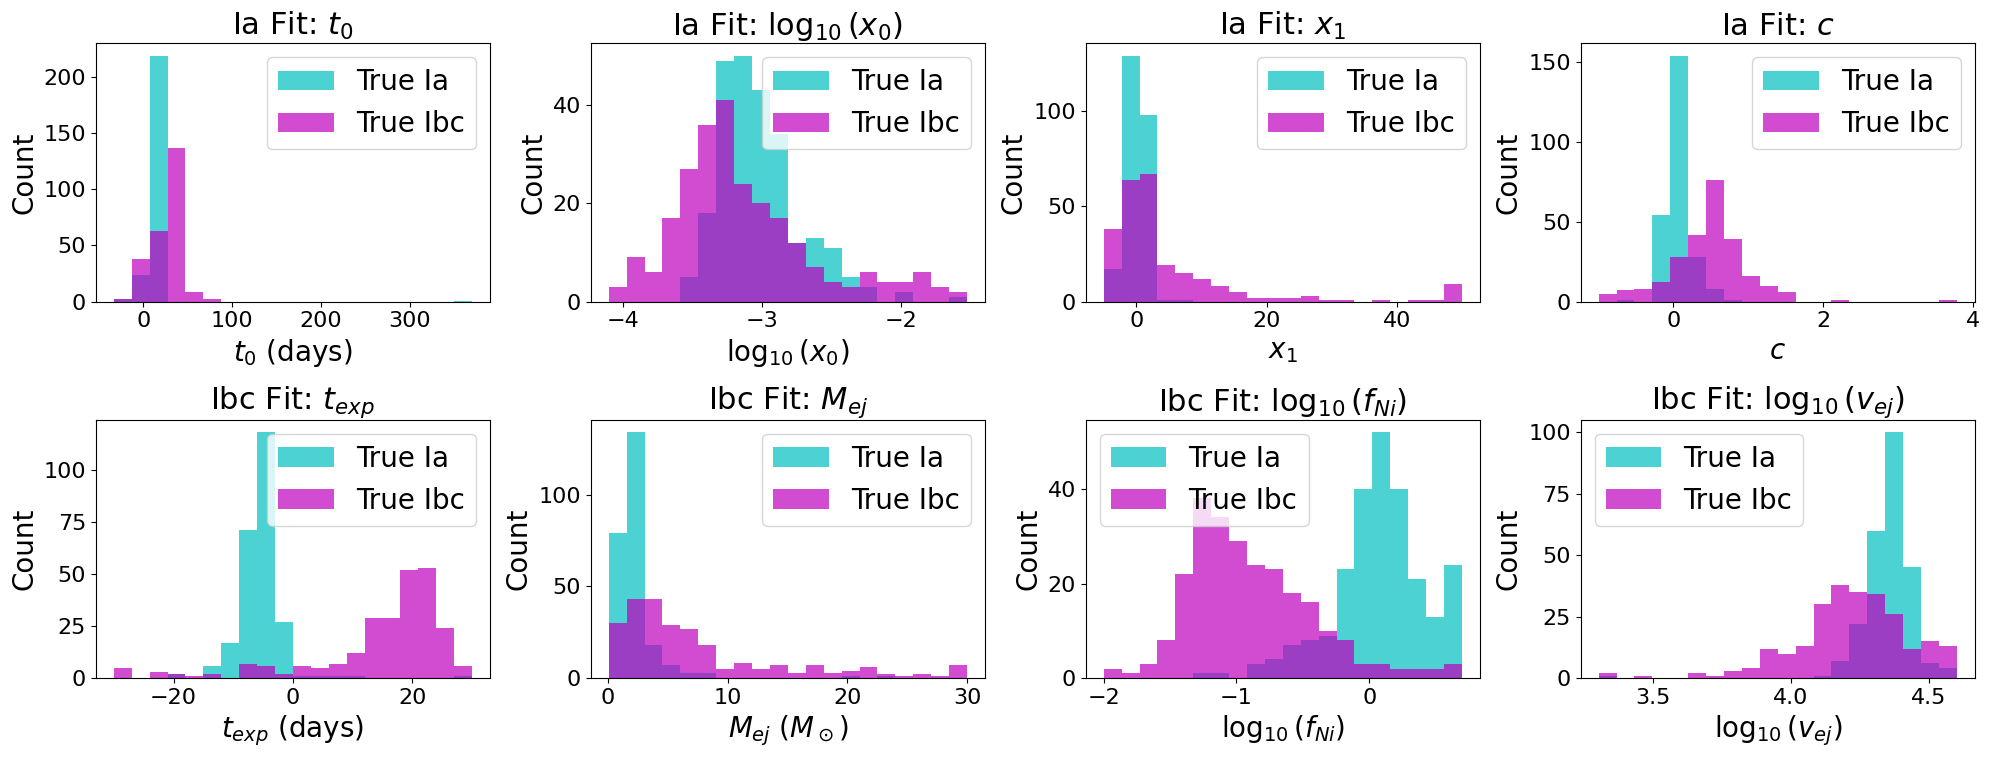

In [306]:
param_labels = {
    't0': r'$t_0$ (days)',
    'log_x0': r'$\log_{10}(x_0)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$ (days)',
    'mej': r'$M_{ej}$ ($M_\odot$)',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'x0': r'$\log_{10}(x_0)$',
}

param_labels_no_units = {
    't0': r'$t_0$',
    'log_x0': r'$\log_{10}(x_0)$',
    'x1': r'$x_1$',
    'c': r'$c$',
    'texp': r'$t_{exp}$',
    'mej': r'$M_{ej}$',
    'log_fni': r'$\log_{10}(f_{Ni})$',
    'log_vej': r'$\log_{10}(v_{ej})$',
    'fni': r'$\log_{10}(f_{Ni})$',
    'vej': r'$\log_{10}(v_{ej})$',
    'x0': r'$\log_{10}(x_0)$',
}


labelfontsize = 20
titlefontsize = 22
tickfontsize = 16

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
# fig.suptitle("Histograms of Fitted Parameters for True Ia and Ibc SNe (Colored by True SN Type)")

# Plot Ia fitted parameters
for i, param in enumerate(ia_param_names[:4]):
    ia_values = [sn.ia_fit[param] for sn in true_ia_sne if sn.ia_fit[param] is not None]
    ibc_values = [sn.ia_fit[param] for sn in true_ibc_sne if sn.ia_fit[param] is not None]
    if param == 'x0':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[0, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia')
    axes[0, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc')
    axes[0, i].set_title(f"Ia Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[0, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[0, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[0, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[0, i].legend(fontsize=labelfontsize)

# Plot Ibc fitted parameters
for i, param in enumerate(ibc_param_names[:4]):
    ia_values = [sn.ibc_fit[param] for sn in true_ia_sne if sn.ibc_fit[param] is not None]
    ibc_values = [sn.ibc_fit[param] for sn in true_ibc_sne if sn.ibc_fit[param] is not None]
    if param == 'vej' or param == 'fni':
        ia_values = [np.log10(v) for v in ia_values if v > 0]
        ibc_values = [np.log10(v) for v in ibc_values if v > 0]
    all_values = ia_values + ibc_values
    bins = np.histogram_bin_edges(all_values, bins=20)
    axes[1, i].hist(ia_values, bins=bins, color='c', alpha=0.7, label='True Ia')
    axes[1, i].hist(ibc_values, bins=bins, color='m', alpha=0.7, label='True Ibc')
    axes[1, i].set_title(f"Ibc Fit: {param_labels_no_units[param]}", fontsize=titlefontsize )
    axes[1, i].set_xlabel(param_labels[param], fontsize = labelfontsize)
    axes[1, i].set_ylabel("Count", fontsize=labelfontsize)
    axes[1, i].tick_params(axis='both', labelsize=tickfontsize)
    axes[1, i].legend(fontsize=labelfontsize)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [307]:
# fig.savefig("figures/fitted_params_histogram.pdf", bbox_inches='tight')

Here we have 8 parameters that we can use to constrain the mixing fraction

In [308]:
# This is the log likelihood function for the distribution of one parameter 
# assuming a mixture of two Gaussians.
# x is the parameter value, samples are the observed data, and alpha is the mixing fraction
def log_likelihood(x, samples, alpha):
    mu1, sigma1, mu2, sigma2 = x
    first_term = alpha * norm.pdf(samples, mu1, sigma1)
    second_term = (1 - alpha) * norm.pdf(samples, mu2, sigma2)
    return np.sum(np.log(first_term + second_term))

In [309]:
def get_param_samples(param_name, sn_sample = all_sne):
    if param_name in ia_param_names:
        return np.array([sn.ia_fit[param_name] for sn in sn_sample])
    elif param_name in ibc_param_names:
        return np.array([sn.ibc_fit[param_name] for sn in sn_sample])
    else:
        raise ValueError(f"Parameter {param_name} not recognized in either Ia or Ibc SNe.")

(array([450.,  21.,   8.,   6.,   6.,   1.,   2.,   1.,   0.,   2.]),
 array([7.88257576e-05, 3.03767383e-03, 5.99652190e-03, 8.95536997e-03,
        1.19142180e-02, 1.48730661e-02, 1.78319142e-02, 2.07907623e-02,
        2.37496103e-02, 2.67084584e-02, 2.96673065e-02]),
 <BarContainer object of 10 artists>)

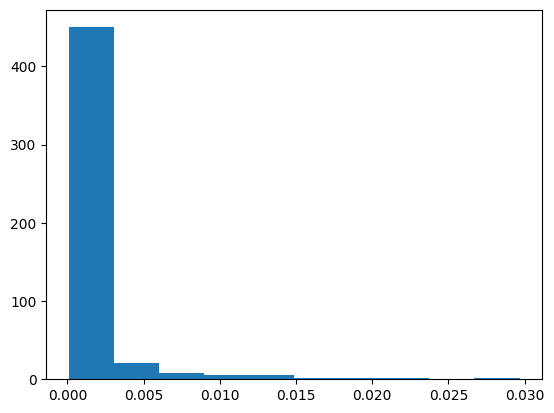

In [310]:
plt.hist(get_param_samples('x0'))

In [311]:
np.shape(get_param_samples('log_vej').reshape(-1, 1))

(497, 1)

In [312]:
# Fit initial guesses
params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']

mus_a = {}
mus_b = {}
sigmas_a = {}
sigmas_b = {}

for param_name in params_to_use:
    # samples = get_param_samples(param_name).reshape(-1, 1)
    # gm = GaussianMixture(n_components=2).fit(samples)
    # mus_a[param_name] = gm.means_[0][0]
    # mus_b[param_name] = gm.means_[1][0]
    # sigmas_a[param_name] = np.sqrt(gm.covariances_[0][0][0])
    # sigmas_b[param_name] = np.sqrt(gm.covariances_[1][0][0])
    # print(param_name, gm.weights_, sigmas_a[param_name], sigmas_b[param_name])
    mus_a[param_name] = np.median(get_param_samples(param_name)) - np.std(get_param_samples(param_name))
    mus_b[param_name] = np.median(get_param_samples(param_name)) + np.std(get_param_samples(param_name))
    sigmas_a[param_name] = np.std(get_param_samples(param_name))
    sigmas_b[param_name] = np.std(get_param_samples(param_name))

In [313]:
# from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2).fit(get_param_samples('x1').reshape(-1, 1))
gm.means_, gm.covariances_**0.5, gm.weights_

(array([[ 0.01640678],
        [16.04564736]]),
 array([[[ 1.83002494]],
 
        [[15.49217402]]]),
 array([0.8409466, 0.1590534]))

In [314]:
num_epochs = 200
lls = np.zeros(num_epochs)


# mus_a = {'t0': 20, 'x0': 0.0001, 'x1': 2, 'c': 0, 'texp': 0.5, 'mej': 8, 'fni': 0.05, 'log_vej': 4.3}
# mus_b = {'t0': 20, 'x0': 0.0001, 'x1': 0.5, 'c': 0.6, 'texp': 5, 'mej': 2, 'fni': 0.49, 'log_vej': 3.9}
# sigmas_a = {'t0': 10, 'x0': 5e-4, 'x1': 0.01, 'c': 0.1, 'texp': 0.2, 'mej': 2, 'fni': 0.01, 'log_vej': 0.05}
# sigmas_b = {'t0': 10, 'x0': 5e-4, 'x1': 1, 'c': 0.3, 'texp': 3, 'mej': 2, 'fni': 5e-2, 'log_vej': 0.2}


alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
alpha = 0.5  # Mixing fraction
gammas_a = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}
gammas_b = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}

# params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']
params_to_use = ['c', 'mej', 'x1', 'log_x0', 'log_fni', 'log_vej']

# params_to_use = list(mus_a.keys())  # Use all parameters for fitting



# there are two populations, a and b
for epoch in range(num_epochs):
    # for param_name in list(mus_a.keys())[:3]:
    for param_name in params_to_use:
        param_samples = get_param_samples(param_name)

        # plt.hist(param_samples)
        # plt.show()

        # print(mus_a[param_name], sigmas_a[param_name])
        # the gammas are weights for every sample
        gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
        gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
        
        # print(param_name)
        # print(np.sum(gammas_a[param_name]), np.sum(gammas_b[param_name]))
        # print(sum(np.isnan(gammas_a[param_name])), sum(np.isinf(gammas_a[param_name])))

        # Normalize over parameter
        gamma_total = (gammas_a[param_name] + gammas_b[param_name])
        gammas_a[param_name] /= gamma_total
        gammas_b[param_name] /= gamma_total
        

        mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
        mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
        sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
        sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

        if sigmas_a[param_name] < 0.001:
            sigmas_a[param_name] = 0.001
        if sigmas_b[param_name] < 0.001:
            sigmas_b[param_name] = 0.001

    
    # Here we can use information from all parameters to constrain the mixing fraction
    # alpha is the fraction of parameter a, parameter b has 1 - alpha
    alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
    alphas[epoch] = alpha
    print("Alpha", alpha)

    # Calculate log likelihood for the current epoch
    for param_name in params_to_use:
        lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]], get_param_samples(param_name), alpha)

print(lls[-1])
    

Alpha 0.477351834526987
Alpha 0.5332087368452334
Alpha 0.5688951421933212
Alpha 0.5904100145003784
Alpha 0.6030139941401216
Alpha 0.6106867387212839
Alpha 0.6158221789818015
Alpha 0.6196719166671606
Alpha 0.622850914334708
Alpha 0.62565392562414
Alpha 0.6282228786360254
Alpha 0.6306291961923263
Alpha 0.6329125080554455
Alpha 0.6350981948452081
Alpha 0.6372050318856157
Alpha 0.6392483488101379
Alpha 0.6412412272332023
Alpha 0.6431948801654748
Alpha 0.6451187184531844
Alpha 0.647020321723313
Alpha 0.6489054053482031
Alpha 0.6507778215323243
Alpha 0.6526396103159295
Alpha 0.654491106234428
Alpha 0.656331100368856
Alpha 0.6581570524523727
Alpha 0.6599653428960311
Alpha 0.6617515505173428
Alpha 0.6635107391756552
Alpha 0.6652377360284479
Alpha 0.6669273858394724
Alpha 0.6685747692908068
Alpha 0.6701753778070675
Alpha 0.6717252421117458
Alpha 0.6732210158583598
Alpha 0.6746600187519011
Alpha 0.6760402454505043
Alpha 0.677360347314191
Alpha 0.678619593992387
Alpha 0.6798178212043212
Alpha 0.6

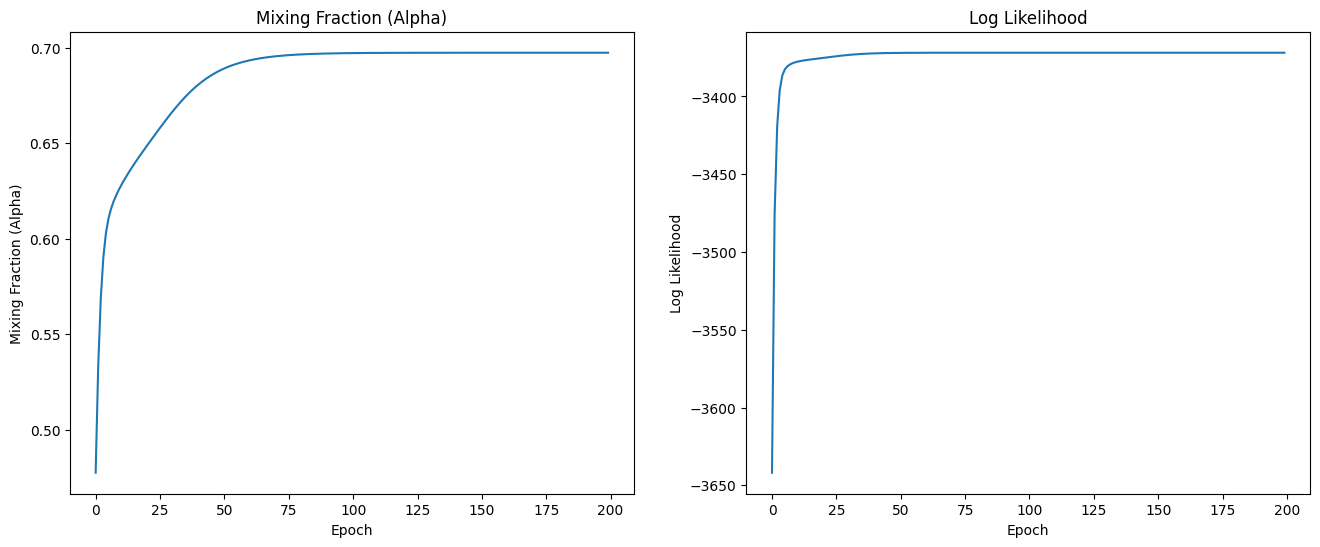

In [315]:
fig, ax = plt.subplots(1,2, figsize=(16, 6))
ax[0].plot(alphas)
ax[1].plot(lls)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Mixing Fraction (Alpha)")
ax[0].set_title("Mixing Fraction (Alpha)")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Log Likelihood")
ax[1].set_title("Log Likelihood")

plt.show()

In [316]:
prob_a = np.ones(len(all_sne))

for i in range(len(all_sne)):
    s = 0
    b = 0
    for param in params_to_use:
        s += gammas_a[param][i]
        b += gammas_b[param][i]
    prob_a[i] = s / (s + b)

(array([  2.,   9.,  12.,  24.,  44.,  86., 147.,  83.,  48.,  42.]),
 array([0.2666627 , 0.33399806, 0.40133342, 0.46866878, 0.53600414,
        0.6033395 , 0.67067486, 0.73801022, 0.80534558, 0.87268094,
        0.9400163 ]),
 <BarContainer object of 10 artists>)

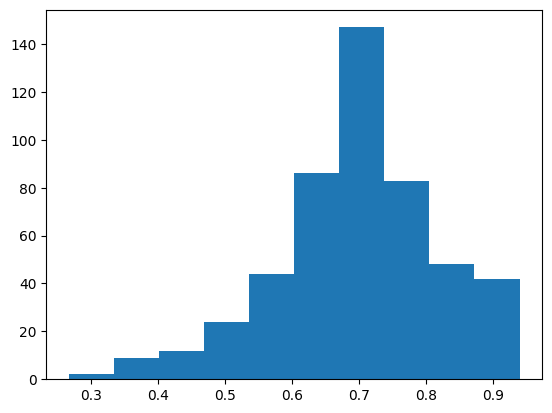

In [317]:
plt.hist(prob_a)

In [318]:
classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in all_sne]

# true_classes

245 32 1 219
0.5573440643863179


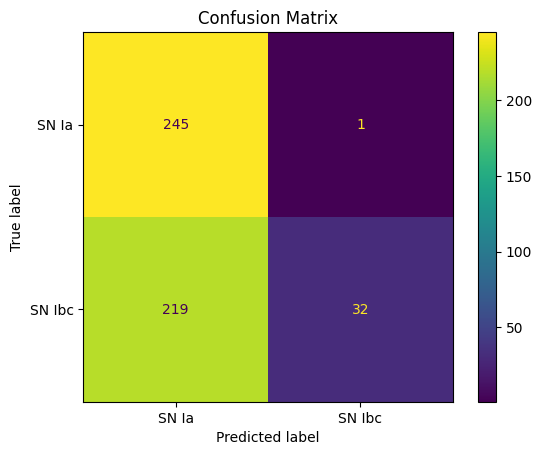

In [319]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

cm = confusion_matrix(true_classes, classifications, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [320]:
classifications_rough = np.ones(len(all_sne))
for i in range(len(all_sne)):
    probs = np.array([gammas_a[param][i] for param in params_to_use])
    num_a = sum(probs >= 0.5)
    if num_a > 4:
        classifications_rough[i] = 0
classifications_rough = ['SN Ia' if i == 0 else 'SN Ibc' for i in classifications_rough]


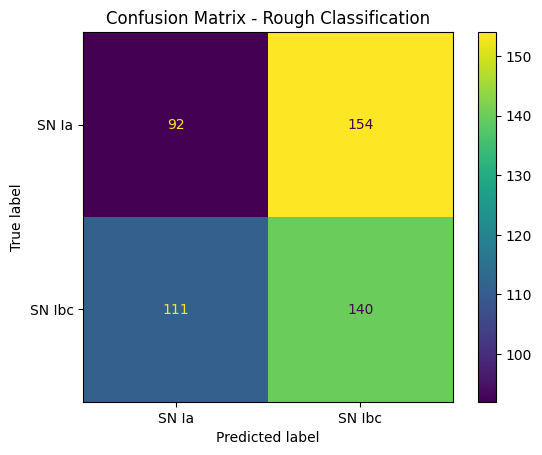

92 140 154 111
0.46680080482897385


In [321]:
num_correct_ia = 0
num_correct_ibc = 0
num_wrong_true_ia = 0
num_wrong_true_ibc = 0


for a,b in zip(true_classes, classifications_rough):
    if a == 'SN Ia':
        if b == 'SN Ia':
            num_correct_ia += 1
        else:
            num_wrong_true_ia += 1
    else:
        if b == 'SN Ibc':
            num_correct_ibc += 1
        else:
            num_wrong_true_ibc += 1

cm = confusion_matrix(true_classes, classifications_rough, labels=['SN Ia', 'SN Ibc'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SN Ia', 'SN Ibc'])
disp.plot()
plt.title("Confusion Matrix - Rough Classification")
plt.show()

print(num_correct_ia, num_correct_ibc, num_wrong_true_ia, num_wrong_true_ibc)
print((num_correct_ia + num_correct_ibc) / len(all_sne))

In [322]:
mus_a, mus_b, sigmas_a, sigmas_b

({'t0': -8.761403948101844,
  'c': 0.16487396411267854,
  'mej': 2.248595892231857,
  'texp': -16.07353640457862,
  'x1': 0.0338117645205678,
  'log_x0': -3.1856707007257157,
  'log_fni': -0.7294069881148794,
  'log_vej': 4.247562939065603},
 {'t0': 35.334338820447286,
  'c': 0.506077697973685,
  'mej': 10.984165873465807,
  'texp': 10.761723781007944,
  'x1': 11.782650964730538,
  'log_x0': -2.827797884637731,
  'log_fni': 0.22206890793314135,
  'log_vej': 4.363792520768602},
 {'t0': 22.047871384274565,
  'c': 0.25913823720055223,
  'mej': 1.229827638140109,
  'texp': 13.417630092793281,
  'x1': 1.6337485988045237,
  'log_x0': 0.24523023979937839,
  'log_fni': 0.5288723698420408,
  'log_vej': 0.20575201200185902},
 {'t0': 22.047871384274565,
  'c': 0.6354616569080244,
  'mej': 7.411731409801438,
  'texp': 13.417630092793281,
  'x1': 15.220108790075663,
  'log_x0': 0.5911535855212438,
  'log_fni': 0.264038825958547,
  'log_vej': 0.04369732040204016})

In [323]:
# for n in sigmas_b.keys():
#     if sigmas_b[n] <= 0.01:
#         sigmas_b[n] = 0.01

# for n in sigmas_a.keys():
#     if sigmas_a[n] <= 0.01:
#         sigmas_a[n] = 0.01

In [324]:
# sigmas_a['x0'] = 1e-5
# sigmas_b['x0'] = 1e-6

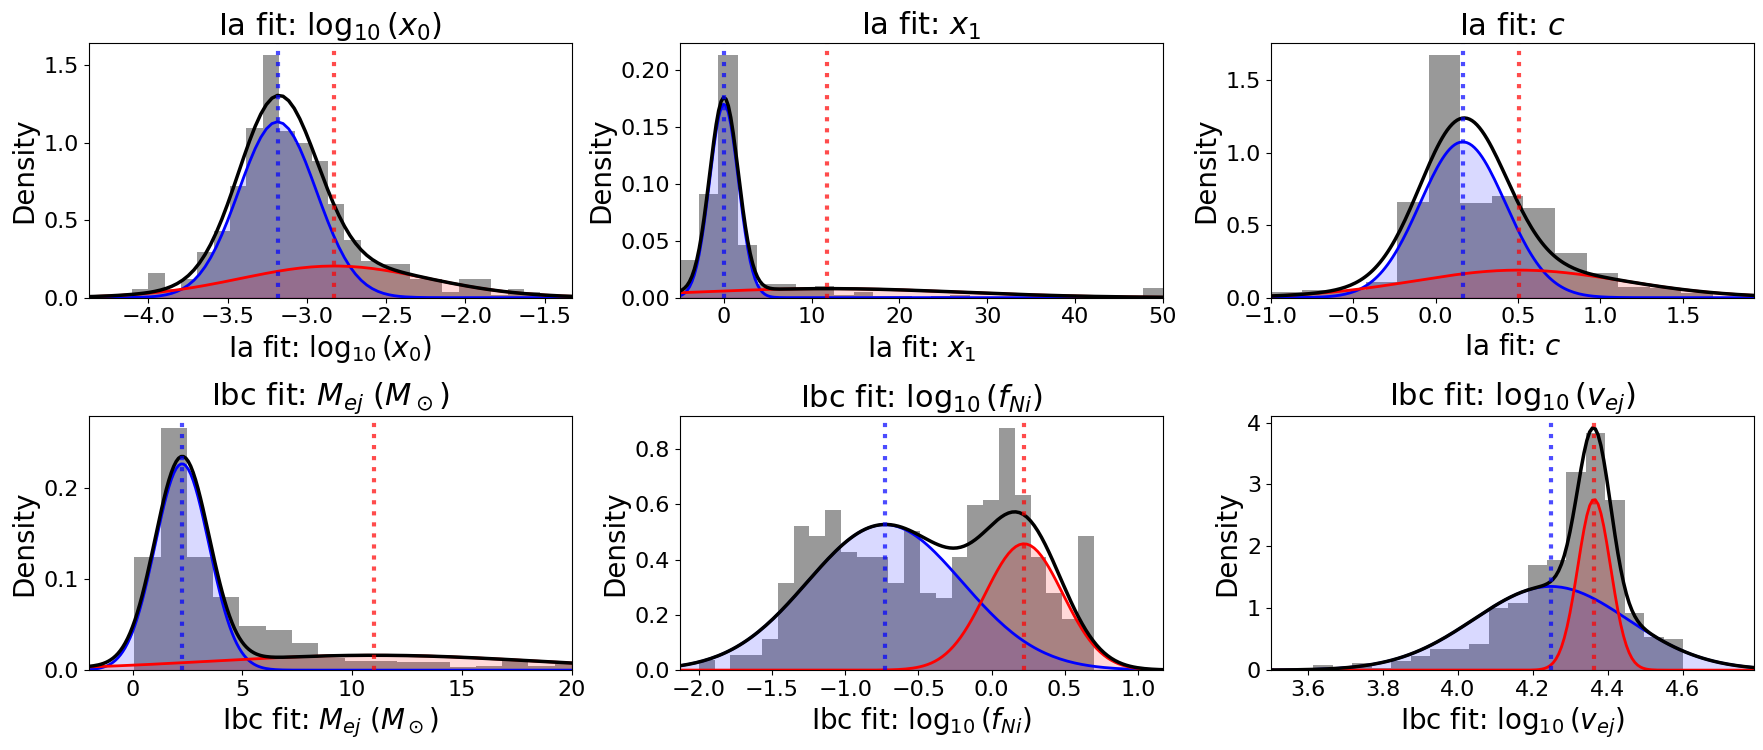


Fitted Gaussian Mixture Parameters:
----------------------------------------------------------------------
Parameter           μ_A        σ_A        μ_B        σ_B
----------------------------------------------------------------------
log_x0          -3.1857     0.2452    -2.8278     0.5912
x1               0.0338     1.6337    11.7827    15.2201
c                0.1649     0.2591     0.5061     0.6355
mej              2.2486     1.2298    10.9842     7.4117
log_fni         -0.7294     0.5289     0.2221     0.2640
log_vej          4.2476     0.2058     4.3638     0.0437


In [325]:
# Define x ranges for plotting
x_ranges = {
    't0': np.linspace(-50, 100, 200),
    'log_x0': np.linspace(-6, 1, 200),
    'x1': np.linspace(-5, 50, 200),
    'c': np.linspace(-1, 2, 200),
    'texp': np.linspace(-20, 50, 200),
    'mej': np.linspace(-2, 20, 200),
    'log_fni': np.linspace(-3, 2, 200),
    'log_vej': np.linspace(3.5, 5, 200)
}

# Parameter display names
param_labels = {
    't0': r'Ia fit: $t_0$ (days)',
    'log_x0': r'Ia fit: $\log_{10}(x_0)$',
    'x1': r'Ia fit: $x_1$',
    'c': r'Ia fit: $c$',
    'texp': r'Ibc fit: $t_{exp}$ (days)',
    'mej': r'Ibc fit: $M_{ej}$ ($M_\odot$)',
    'log_fni': r'Ibc fit: $\log_{10}(f_{Ni})$',
    'log_vej': r'Ibc fit: $\log_{10}(v_{ej})$'
}

# Create figure with better styling
# fig.suptitle(f"Gaussian Mixture Model Fits (Mixing Fraction α = {alpha:.3f})", fontsize=14, fontweight='bold')

# params_plot = ['t0', 'log_x0', 'x1', 'c', 'texp', 'mej', 'log_fni', 'log_vej']
params_plot = ['log_x0', 'x1', 'c', 'mej', 'log_fni', 'log_vej']
fig, axes = plt.subplots(2, len(params_plot) // 2, figsize=(18, 8))


for idx, param in enumerate(params_plot):
    ax = axes.flat[idx]
    
    # Get samples and set up parameters
    samples = get_param_samples(param)
    mu_a, mu_b = mus_a[param], mus_b[param]
    sigma_a, sigma_b = sigmas_a[param], sigmas_b[param]

    x = x_ranges[param]
    
    # Plot histogram with better styling
    n, bins, patches = ax.hist(samples, bins=25, density=True,  alpha=0.4,
                                color='black', linewidth=0.5,
                                label='Data')
    
    # Compute mixture components
    y_a = alpha * norm.pdf(x, mu_a, sigma_a)
    y_b = (1 - alpha) * norm.pdf(x, mu_b, sigma_b)
    y_mix = y_a + y_b
    
    # Plot components with better styling
    ax.plot(x, y_a, 'b-', linewidth=2, label=f'Component A (α={alpha:.2f})')
    ax.plot(x, y_b, 'r-', linewidth=2, label=f'Component B (1-α={1-alpha:.2f})')
    ax.plot(x, y_mix, 'k-', linewidth=2.5, label='Mixture')
    
    # Fill under curves for visibility
    ax.fill_between(x, y_a, alpha=0.15, color='blue')
    ax.fill_between(x, y_b, alpha=0.15, color='red')
    
    # Set axis limits based on data
    data_min, data_max = np.percentile(samples, [1, 99])
    x_margin = (data_max - data_min) * 0.2
    ax.set_xlim(max(x[0], data_min - x_margin), min(x[-1], data_max + x_margin))
    
    # Styling
    ax.set_xlabel(param_labels[param], fontsize=labelfontsize)
    ax.set_ylabel('Density', fontsize=labelfontsize)
    ax.set_title(param_labels[param], fontsize=titlefontsize)
    # ax.legend(fontsize=labelfontsize, loc='upper right')
    ax.tick_params(axis='both', labelsize=tickfontsize)

    
    # Add mean markers
    ax.axvline(mu_a, color='blue', linestyle=':', alpha=0.7, linewidth=3)
    ax.axvline(mu_b, color='red', linestyle=':', alpha=0.7, linewidth=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig.savefig("figures/gmm_results.pdf", bbox_inches='tight')

# Print summary statistics
print("\nFitted Gaussian Mixture Parameters:")
print("-" * 70)
print(f"{'Parameter':<12} {'μ_A':>10} {'σ_A':>10} {'μ_B':>10} {'σ_B':>10}")
print("-" * 70)
for param in params_plot:
        print(f"{param:<12} {mus_a[param]:>10.4f} {sigmas_a[param]:>10.4f} {mus_b[param]:>10.4f} {sigmas_b[param]:>10.4f}")

In [326]:
def fit_gmm(sn_sample = all_sne, initial_alpha = 0.5, verbose = False):

    # Fit initial guesses
    params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']

    mus_a = {}
    mus_b = {}
    sigmas_a = {}
    sigmas_b = {}

    print(len(sn_sample))
    for param_name in params_to_use:
        mus_a[param_name] = np.median(get_param_samples(param_name, sn_sample)) - np.std(get_param_samples(param_name, sn_sample))
        mus_b[param_name] = np.median(get_param_samples(param_name, sn_sample)) + np.std(get_param_samples(param_name, sn_sample))
        sigmas_a[param_name] = np.std(get_param_samples(param_name, sn_sample))
        sigmas_b[param_name] = np.std(get_param_samples(param_name, sn_sample))

    num_epochs = 200
    lls = np.zeros(num_epochs)

    alphas = np.zeros(num_epochs)  # Store alpha values for each epoch
    alpha = initial_alpha  # Mixing fraction initilization
    gammas_a = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}
    gammas_b = {'texp': [], 'mej': [], 'log_fni': [], 'log_vej': [], 't0': [], 'log_x0': [], 'x1': [], 'c': []}

    params_to_use = ['t0', 'c', 'mej', 'texp', 'x1', 'log_x0', 'log_fni', 'log_vej']


    # there are two populations, a and b
    for epoch in range(num_epochs):
        # for param_name in list(mus_a.keys())[:3]:
        for param_name in params_to_use:
            param_samples = get_param_samples(param_name, sn_sample)

            # the gammas are weights for every sample
            gammas_a[param_name] = alpha * norm.pdf(param_samples, mus_a[param_name], sigmas_a[param_name])
            gammas_b[param_name] = (1 - alpha) * norm.pdf(param_samples, mus_b[param_name], sigmas_b[param_name])
    
            # Normalize over parameter
            gamma_total = (gammas_a[param_name] + gammas_b[param_name])
            gammas_a[param_name] /= gamma_total
            gammas_b[param_name] /= gamma_total
            

            mus_a[param_name] = np.sum(gammas_a[param_name] * param_samples) / np.sum(gammas_a[param_name])
            mus_b[param_name] = np.sum(gammas_b[param_name] * param_samples) / np.sum(gammas_b[param_name])
            sigmas_a[param_name] = np.sqrt(np.sum(gammas_a[param_name] * (param_samples - mus_a[param_name])**2) / np.sum(gammas_a[param_name]))
            sigmas_b[param_name] = np.sqrt(np.sum(gammas_b[param_name] * (param_samples - mus_b[param_name])**2) / np.sum(gammas_b[param_name]))

            if sigmas_a[param_name] < 0.001:
                sigmas_a[param_name] = 0.001
            if sigmas_b[param_name] < 0.001:
                sigmas_b[param_name] = 0.001

        
        # Here we can use information from all parameters to constrain the mixing fraction
        # alpha is the fraction of parameter a, parameter b has 1 - alpha
        alpha = np.mean(np.concatenate([gammas_a[param_name] for param_name in params_to_use]))
        alphas[epoch] = alpha
        if verbose:
            print("Alpha", alpha)

        # Calculate log likelihood for the current epoch
        for param_name in params_to_use:
            lls[epoch] += log_likelihood([mus_a[param_name], sigmas_a[param_name], mus_b[param_name], sigmas_b[param_name]],
                                         get_param_samples(param_name, sn_sample), alpha)
    return alpha, lls[-1], gammas_a, gammas_b
        

In [327]:
def classify_sample(sn_sample, gammas_a, gammas_b):

    prob_a = np.ones(len(sn_sample))

    for i in range(len(sn_sample)):
        s = 0
        b = 0
        for param in params_to_use:
            s += gammas_a[param][i]
            b += gammas_b[param][i]
        prob_a[i] = s / (s + b)

    classifications = ['SN Ia' if p >= 0.5 else 'SN Ibc' for p in prob_a]
    true_classes = ['SN Ia' if sn.true_class == 'SN Ia' else 'SN Ibc' for sn in sn_sample]

    # Calculate accuracy
    num_correct_ia = 0
    num_correct_ibc = 0
    num_wrong_true_ia = 0
    num_wrong_true_ibc = 0

    for a,b in zip(true_classes, classifications):
        if a == 'SN Ia':
            if b == 'SN Ia':
                num_correct_ia += 1
            else:
                num_wrong_true_ia += 1
        else:
            if b == 'SN Ibc':
                num_correct_ibc += 1
            else:
                num_wrong_true_ibc += 1

    accuracy = (num_correct_ia + num_correct_ibc) / len(sn_sample)
    return accuracy

In [328]:
fit_gmm(sn_sample = all_sne, initial_alpha = 0.6)
for i in range(1,10):
    print(f"Initial alpha: {i/10}")
    final_alpha, final_ll, final_gammas_a, final_gammas_b = fit_gmm(sn_sample = all_sne, initial_alpha = i/10)
    print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
    print("Classification accuracy:", classify_sample(all_sne, final_gammas_a, final_gammas_b))


497
Initial alpha: 0.1
497
Final alpha: 0.5409734955197574 Final log likelihood: -7265.9987697541155
Classification accuracy: 0.6599597585513078
Initial alpha: 0.2
497
Final alpha: 0.540973495519759 Final log likelihood: -7265.9987697541155
Classification accuracy: 0.6599597585513078
Initial alpha: 0.3
497
Final alpha: 0.5409734955197602 Final log likelihood: -7265.998769754115
Classification accuracy: 0.6599597585513078
Initial alpha: 0.4
497
Final alpha: 0.5409734955197619 Final log likelihood: -7265.998769754115
Classification accuracy: 0.6599597585513078
Initial alpha: 0.5
497
Final alpha: 0.5409734955197643 Final log likelihood: -7265.998769754115
Classification accuracy: 0.6599597585513078
Initial alpha: 0.6
497
Final alpha: 0.5751803638485078 Final log likelihood: -7260.759657463689
Classification accuracy: 0.6539235412474849
Initial alpha: 0.7
497
Final alpha: 0.5751803638491423 Final log likelihood: -7260.759657463689
Classification accuracy: 0.6539235412474849
Initial alpha: 

In [329]:
len(true_ia_sne), len(true_ibc_sne)

(246, 251)

270
295
320
345
370
395
420
445
470
495
269
294
319
344
369
394
419
444
469
494


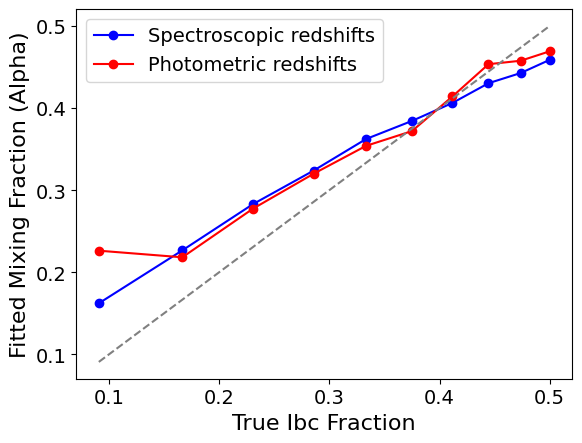

In [330]:
ratios = [(25 * (i + 1))/ (25 * (i + 1) + 250) for i in range(10)]

def mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios):
    final_alphas = []
    accuracies = []
    for i in range(10):
        # print(25*(i + 1))
        split_population = np.concatenate((true_ia_sne, true_ibc_sne[1:25*(i + 1)]))
        # print(f"Population split: {(25 * (i + 1))/ (25 * (i + 1) + 250)}")
        # final_alpha, final_ll = fit_gmm(sn_sample = split_population, initial_alpha = (25 * (i + 1))/ (25 * (i + 1) + 250))
        final_alpha, final_llm, final_gammas_a, final_gammas_b = fit_gmm(sn_sample = split_population, initial_alpha = 0.1)
        # print(f"Final alpha: {final_alpha}", f"Final log likelihood: {final_ll}")
        final_alphas.append(final_alpha)
        accuracies.append(classify_sample(split_population, final_gammas_a, final_gammas_b))
    return final_alphas, accuracies

final_alphas_spec, accuracies_spec = mixing_fraction_analysis(true_ia_sne, true_ibc_sne, ratios)
final_alphas_phot, accuracies_phot = mixing_fraction_analysis(true_ia_phot_sne, true_ibc_phot_sne, ratios)

plt.plot(ratios, 1 - np.array(final_alphas_spec), marker='o', color='blue', label='Spectroscopic redshifts')
plt.plot(ratios, 1 - np.array(final_alphas_phot), marker='o', color='red', label='Photometric redshifts')
plt.plot(ratios, ratios, linestyle='--', color='gray')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Fitted Mixing Fraction (Alpha)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()

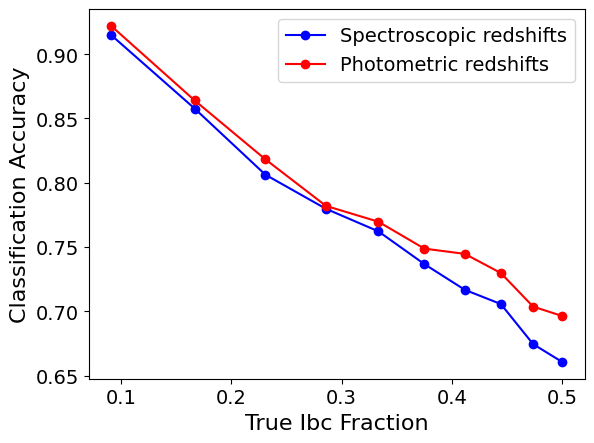

In [331]:
plt.plot(ratios, accuracies_spec, marker='o', color='blue', label='Spectroscopic redshifts')
plt.plot(ratios, accuracies_phot, marker='o', color='red', label='Photometric redshifts')
plt.xlabel("True Ibc Fraction", fontsize=16)
plt.ylabel("Classification Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("figures/alpha_vs_true_fraction.pdf", bbox_inches='tight')
plt.show()